In [1]:
# preamble
import lowry
Q_ = lowry.ureg.Quantity
import matplotlib.pyplot as plt, mpld3

First we need to input the data we've collected.

In [2]:
# The Cessna 172P from the paper (Lowry, 1995)
c172p = lowry.bootstrap({
    'W0': Q_('2400 lbf'),
    'S': Q_('174 ft^2'),
    'A': 7.378,
    'M0': Q_('311.2 ft lbf'),
    'C': 0.12,
    'd': Q_('6.25 ft'),
    'drag': {
        'W': Q_('2200 lbf'),
        'h_p': Q_('5000 ft'),
        'T': None, # h_p is h_rho
        'VCbg': Q_('70.0 kts'),
        'dh_p': Q_('200 ft'),
        'dt': Q_('17.0 s'),
    },
    'thrust': {
        'W': Q_('2200 lbf'),
        'T': None,
        'h_p': Q_('5000 ft'),
        'VCx': Q_('60.5 kts'),
        'VC_M': Q_('105 kts'),
    }
})

# My airplane, an Aerotrek A220
N761S = lowry.bootstrap({
    'W0': Q_('1235 lbf'),
    'S': Q_('122.53 ft^2'),
    'A': 6.74,
    'P0': Q_('100 horsepower'),
    'n0': Q_(5800 / 2.43, 'rpm'),
    'M0': Q_(122, 'N m'),
    'd': Q_('5.183 ft'),
    'drag': {
        'W': Q_('1010 lbf'),
        'h_p': Q_('5500 ft'),
        'T': Q_(83, 'degF'),
        'VCbg': Q_('65.5 mph'),
        'dh_p': Q_('400 ft'),
        'dt': Q_('48.92 s'),
    },
    'thrust': {
        'W': Q_('1010 lbf'),
        'h_p': Q_('5600 ft'),
        'T': Q_(72, 'degF'),
        'VCx': Q_('63 mph'),
        'VC_M': Q_('115 mph'),
    }
})

In [3]:
# select the plate you want to use
plate = N761S

# altitude range you want to plot
hs = [Q_(h, 'ft') for h in range(0, 14500, 250)]

# airspeeds you want to plot
V_unit = 'mph'
vs = [Q_(V, V_unit) for V in range(45, 134)]


## uncomment for Lowry's example
# plate = N6346D
# hs = [Q_(h, 'ft') for h in range(0, 20000, 250)]
# V_unit = 'knot'
# vs = [Q_(V, V_unit) for V in range(40, 120)]
# W0 = plate['W0']

In [4]:
perfMSL = [lowry.performance(plate, plate['W0'], Q_(0, 'ft'), V) for V in vs]
perf8000 = [lowry.performance(plate, 0.75*plate['W0'], Q_(8000, 'ft'), V) for V in vs]

{k: perfMSL[0][k].m_as(V_unit) for k in ('Vy', 'Vx', 'V_M', 'Vm', 'Vbg', 'Vmd')}

{'Vy': 79.97939268193772,
 'Vx': 69.66479145391044,
 'V_M': 117.4793711297436,
 'Vm': 41.31093928786018,
 'Vbg': 72.57262154387087,
 'Vmd': 55.14326765032066}

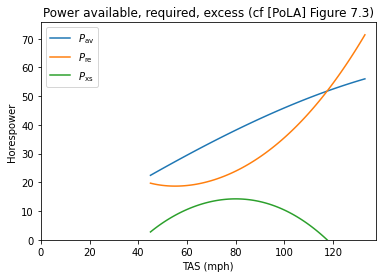

In [5]:
fig, ax = plt.subplots()
ax.plot([V.m_as(V_unit) for V in vs], [x['Pav'].m_as('horsepower') for x in perfMSL], label='$P_\mathrm{av}$')
ax.plot([V.m_as(V_unit) for V in vs], [x['Pre'].m_as('horsepower') for x in perfMSL], label='$P_\mathrm{re}$')
ax.plot([V.m_as(V_unit) for V in vs], [x['Pxs'].m_as('horsepower') for x in perfMSL], label='$P_\mathrm{xs}$')
ax.set_ylim(bottom=0)
ax.set_xlim(left=0)
ax.set_title('Power available, required, excess (cf [PoLA] Figure 7.3)')
ax.set_ylabel('Horespower')
ax.set_xlabel(f"TAS ({V_unit})")
ax.legend()

# TODO tangents and labeled points

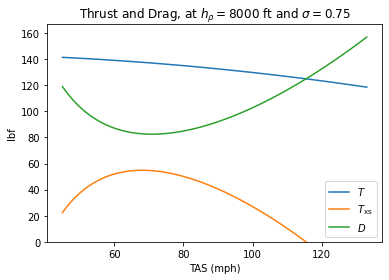

In [6]:
fig, ax = plt.subplots()
ax.plot([V.m_as(V_unit) for V in vs], [x['T'].m_as('lbf') for x in perf8000], label='$T$')
ax.plot([V.m_as(V_unit) for V in vs], [x['Txs'].m_as('lbf') for x in perf8000], label='$T_\mathrm{xs}$')
ax.plot([V.m_as(V_unit) for V in vs], [x['D'].m_as('lbf') for x in perf8000], label='$D$')
ax.set_ylim(bottom=0)
ax.set_title('Thrust and Drag, at $h_\\rho=8000$ ft and $\sigma=0.75$')
ax.set_ylabel('lbf')
ax.set_xlabel(f"TAS ({V_unit})")
ax.legend()

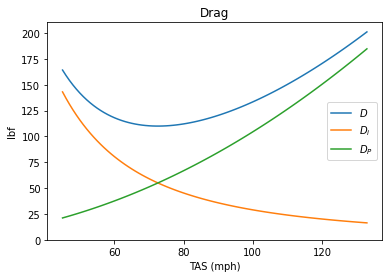

In [7]:
fig, ax = plt.subplots()
ax.plot([V.m_as(V_unit) for V in vs], [x['D'].m_as('lbf') for x in perfMSL], label='$D$')
ax.plot([V.m_as(V_unit) for V in vs], [x['Di'].m_as('lbf') for x in perfMSL], label='$D_i$')
ax.plot([V.m_as(V_unit) for V in vs], [x['Dp'].m_as('lbf') for x in perfMSL], label='$D_P$')
ax.set_ylim(bottom=0)
ax.set_title('Drag')
ax.set_ylabel('lbf')
ax.set_xlabel(f"TAS ({V_unit})")
ax.legend()

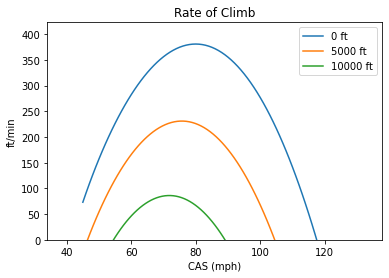

In [8]:
W = plate['W0']
fig, ax = plt.subplots()
for x in [0, 5000, 10000]:
    h = Q_(x, 'ft')
    perf_ = [lowry.performance(plate, W, h, V) for V in vs]
    ax.plot([lowry.cas(V, h).m_as(V_unit) for V in vs], [x['ROC'].m_as('ft/min') for x in perf_], label=f"{h.m_as('ft')} ft")
ax.set_title('Rate of Climb')
ax.set_ylim(bottom=0)
ax.set_ylabel('ft/min')
ax.set_xlabel(f"CAS ({V_unit})")
ax.legend()

# everything seems reasonable to me except the rate of climb.
# Do I really get under 400fpm at gross at sea level DA?

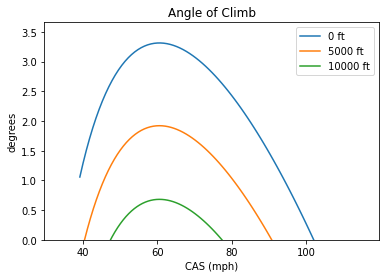

In [9]:
fig, ax = plt.subplots()
for x in [0, 5000, 10000]:
    h = Q_(x, 'ft')
    vs_ = [lowry.cas(V, h) for V in vs]
    perf_ = [lowry.performance(plate, plate['W0'], h, V) for V in vs]
    ax.plot([V.magnitude for V in vs_], [x['gamma'].m_as('deg') for x in perf_], label=f"{h.m_as('ft')} ft")
ax.set_title('Angle of Climb')
ax.set_ylim(bottom=0)
ax.set_ylabel('degrees')
ax.set_xlabel(f"CAS ({V_unit})")
ax.legend()

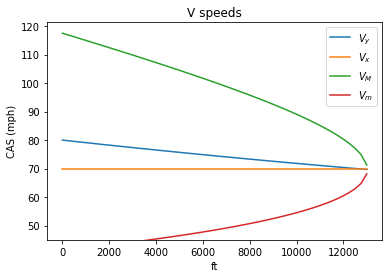

In [10]:
W = plate['W0']
fig, ax = plt.subplots()
perf_ = {h: lowry.performance(plate, W, h) for h in hs}
perf_ = {k:v for k,v in perf_.items() if v['VCx'] <= v['VCy']}
ax.plot([h.m_as('ft') for h in perf_.keys()], [x['VCy'].m_as(V_unit) for x in perf_.values()], label='$V_y$')
ax.plot([h.m_as('ft') for h in perf_.keys()], [x['VCx'].m_as(V_unit) for x in perf_.values()], label='$V_x$')
ax.plot([h.m_as('ft') for h in perf_.keys()], [x['VC_M'].m_as(V_unit) for x in perf_.values()], label='$V_M$')
ax.plot([h.m_as('ft') for h in perf_.keys()], [x['VCm'].m_as(V_unit) for x in perf_.values()], label='$V_m$')
ax.set_title(f'V speeds')
ax.set_ylabel(f'CAS ({V_unit})')
ax.set_xlabel(f"ft")
ax.set_ylim(bottom=vs[0].m_as(V_unit))
ax.legend()

In [11]:
# TODO 
# figure 7.10 ROC vs W
# figure 7.12 ROS vs CAS
# figure 7.13 glide angle vs CAS
# figure 7.14 max ROC vs h_rho

# Vx, Vy, Vbg, Vmd, Vh calibrated vs DA at gross and solo
# some kind of headwind/tailwind;altitude;tas graph
# a weight -> %decrease nomogram? or even better weight -> each v speed

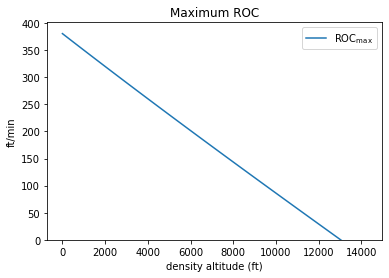

In [18]:
fig, ax = plt.subplots()
W = plate['W0']
ys = [lowry.performance(plate, W, h)['ROC_y'] for h in hs]
ax.plot([h.m_as('ft') for h in hs], [y.m_as('ft/min') for y in ys], label='$\mathrm{ROC}_\mathrm{max}$')
ax.set_ylim(bottom=0)
ax.set_title('Maximum ROC')
ax.set_ylabel('ft/min')
ax.set_xlabel(f"density altitude (ft)")
ax.legend()